In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision as tv
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [2]:
# Detectar si hay una GPU disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Definición de la RBM
class RBM(nn.Module):
    def __init__(self, vsize, hsize, CD_k=1):
        super().__init__()
        self.W = nn.Parameter(torch.randn(hsize, vsize) * 1e-2)  # Pesos
        self.bv = nn.Parameter(torch.randn(vsize) * 1e-2)  # Bias para las visibles
        self.bh = nn.Parameter(torch.randn(hsize) * 1e-2)  # Bias para las ocultas
        self.k = CD_k  # Divergencia Contrastiva

    def sample_h(self, v):
        prob_h = torch.sigmoid(F.linear(v, self.W, self.bh))
        samp_h = torch.bernoulli(prob_h)
        return prob_h, samp_h

    def sample_v(self, h):
        prob_v = torch.sigmoid(F.linear(h, self.W.t(), self.bv))
        samp_v = torch.bernoulli(prob_v)
        return prob_v, samp_v

    def forward(self, v):
        vs = v
        for _i in range(self.k):
            _hp, hs = self.sample_h(vs)
            _vp, vs = self.sample_v(hs)
        return v, vs

    def free_energy(self, v):
        v_bv = v.mv(self.bv)
        hlin = torch.clamp(F.linear(v, self.W, self.bh), -80, 80)
        slog = hlin.exp().add(1).log().sum(1)
        return (-slog - v_bv).mean()

In [4]:
# Definición de la DBN
class DBN(nn.Module):
    def __init__(self, sizes, CD_k=1):
        assert isinstance(sizes, list) or isinstance(sizes, tuple)
        assert all(isinstance(size, int) and size > 0 for size in sizes)
        assert len(sizes) > 1
        super().__init__()
        self.subnet = nn.ModuleList()
        for i in range(len(sizes) - 2):
            self.subnet.append(RBM(sizes[i], sizes[i + 1], CD_k))
        self.output = nn.Linear(sizes[-2], sizes[-1])

    def forward(self, v, depth=None):
        assert depth is None or 0 <= depth < len(self.subnet)
        vi = v
        if depth is not None:
            for i in range(depth):
                _hp, vi = self.subnet[i].sample_h(vi)
            _vp, vo = self.subnet[depth].forward(vi)
        else:
            for rbm in self.subnet:
                _hp, vi = rbm.sample_h(vi)
            vo = self.output(vi)
        return vi, vo


In [5]:
# Parámetros y datos
T = 20  # Número de épocas
B = 50  # Tamaño de batch
sizes = [28 * 28, 500, 500, 2000, 10]  # Arquitectura de Hinton

In [6]:
# Cargar el conjunto de datos MNIST
trn_data = tv.datasets.MNIST(root='./data', train=True, download=True, transform=tv.transforms.ToTensor())
tst_data = tv.datasets.MNIST(root='./data', train=False, download=True, transform=tv.transforms.ToTensor())
trn_load = torch.utils.data.DataLoader(dataset=trn_data, batch_size=B, shuffle=True)
tst_load = torch.utils.data.DataLoader(dataset=tst_data, batch_size=B, shuffle=False)


In [7]:
# Almacenar los stop loss de entrenamiento y validación
train_losses = []
val_losses = []

def validation_loss_free_energy(model, loader, depth):
    total_free_energy = 0
    with torch.inference_mode():
        for images, _ in loader:
            data = images.view(-1, 28 * 28).to(device)
            v0, _ = model(data, depth=depth)  # Obtenemos v0 desde la DBN
            free_energy = model.subnet[depth].free_energy(v0)  # Energía libre en validación
            total_free_energy += free_energy.item()
    return total_free_energy / len(loader)

In [8]:
model = DBN(sizes).to(device)
model.train()

# Entrenamiento de la DBN
for depth in range(len(model.subnet)):
    rbm = model.subnet[depth]
    optim_rbm = optim.SGD(rbm.parameters(), lr=0.01)
    print("Depth:", depth)
    for t in range(T):
        train_loss = 0
        for images, _ in trn_load:
            optim_rbm.zero_grad()
            data = images.view(-1, 28 * 28).to(device)
            v0, vk = model(data, depth)
            loss = rbm.free_energy(v0) - rbm.free_energy(vk)
            loss.backward()
            optim_rbm.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(trn_load))
        val_loss = validation_loss_free_energy(model, tst_load, depth)
        val_losses.append(val_loss)
        print(f"Epoch {t}, Train Loss: {train_loss}, Validation Loss: {val_loss}")



Depth: 0
Epoch 0, Train Loss: -21340.91082763672, Validation Loss: -305.5655830383301
Epoch 1, Train Loss: -16314.683502197266, Validation Loss: -315.06374603271485
Epoch 2, Train Loss: -15340.303314208984, Validation Loss: -321.81851608276367
Epoch 3, Train Loss: -14332.251098632812, Validation Loss: -327.95578399658206
Epoch 4, Train Loss: -13389.153259277344, Validation Loss: -336.1990608215332
Epoch 5, Train Loss: -12448.163330078125, Validation Loss: -343.484384765625
Epoch 6, Train Loss: -11653.104095458984, Validation Loss: -348.56285705566404
Epoch 7, Train Loss: -10858.653991699219, Validation Loss: -354.6524674987793
Epoch 8, Train Loss: -10282.502532958984, Validation Loss: -360.54857803344726
Epoch 9, Train Loss: -9619.570404052734, Validation Loss: -365.15572631835937
Epoch 10, Train Loss: -9128.925415039062, Validation Loss: -371.74102661132815
Epoch 11, Train Loss: -8576.841613769531, Validation Loss: -374.9648988342285
Epoch 12, Train Loss: -8124.403106689453, Validatio

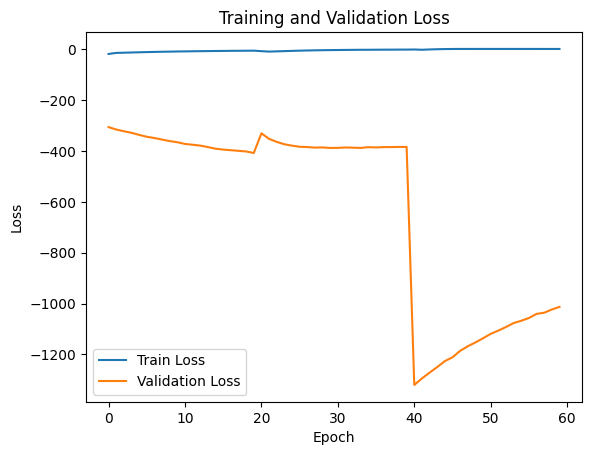

In [9]:
# Graficar las pérdidas
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
# Almacenar stop loss de entrenamiento y validación
ft_train_losses = []
ft_val_losses = []

# Ajuste fino de toda la red
optim_all = optim.Adam(model.parameters())
costf = nn.CrossEntropyLoss()  # CrossEntropyLoss para clasificación

# Función para calcular el loss en validación
def validation_loss(model, loader, costf):
    total_loss = 0
    with torch.inference_mode():
        for images, labels in loader:
            data = images.view(-1, 28 * 28).to(device)
            labels = labels.to(device)
            _x, y = model(data)
            loss = costf(y, labels)
            total_loss += loss.item()
    return total_loss / len(loader)

print("Model fine-tuning")
for t in range(T):
    train_loss = 0
    for images, labels in trn_load:
        optim_all.zero_grad()
        data = images.view(-1, 28 * 28).to(device)
        labels = labels.to(device)
        _x, y = model(data)
        loss = costf(y, labels)
        loss.backward()
        optim_all.step()
        train_loss += loss.item()
    ft_train_losses.append(train_loss / len(trn_load))
    val_loss = validation_loss(model, tst_load, costf)
    ft_val_losses.append(val_loss)
    print(f"Epoch {t}, Train Loss: {train_loss}, Validation Loss: {val_loss}")


Model fine-tuning
Epoch 0, Train Loss: 450.543508477509, Validation Loss: 0.3670223105791956
Epoch 1, Train Loss: 444.99379700422287, Validation Loss: 0.344763068985194
Epoch 2, Train Loss: 448.1887744963169, Validation Loss: 0.3492858103569597
Epoch 3, Train Loss: 442.18706446141005, Validation Loss: 0.3526557986717671
Epoch 4, Train Loss: 440.81241265684366, Validation Loss: 0.3378741413168609
Epoch 5, Train Loss: 440.55666156858206, Validation Loss: 0.3457179767265916
Epoch 6, Train Loss: 442.054252050817, Validation Loss: 0.36413007449358703
Epoch 7, Train Loss: 440.3341685011983, Validation Loss: 0.3521628318540752
Epoch 8, Train Loss: 445.67514396086335, Validation Loss: 0.3495766596030444
Epoch 9, Train Loss: 443.85367104038596, Validation Loss: 0.347163047241047
Epoch 10, Train Loss: 443.0728187710047, Validation Loss: 0.35173693193122746
Epoch 11, Train Loss: 445.2686524428427, Validation Loss: 0.3495543851517141
Epoch 12, Train Loss: 443.87929947301745, Validation Loss: 0.344

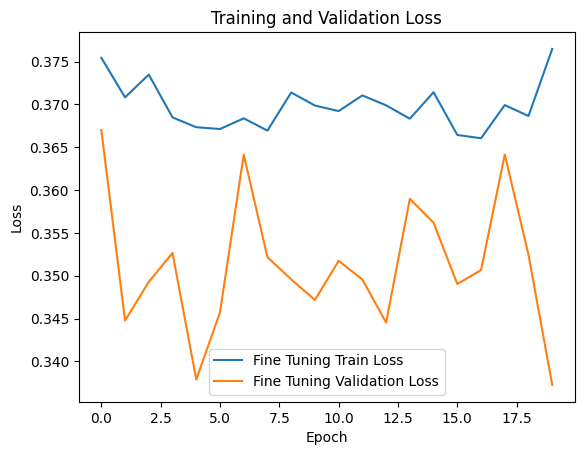

In [15]:
# Graficar las pérdidas
plt.figure()
plt.plot(ft_train_losses, label='Fine Tuning Train Loss')
plt.plot(ft_val_losses, label='Fine Tuning Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
# Evaluación del modelo
model.eval()
y_true = []
y_pred = []
with torch.inference_mode():
    for images, labels in tst_load:
        data = images.view(-1, 28 * 28).to(device)
        _, y = model(data)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(y.cpu().argmax(dim=1).cpu().numpy())


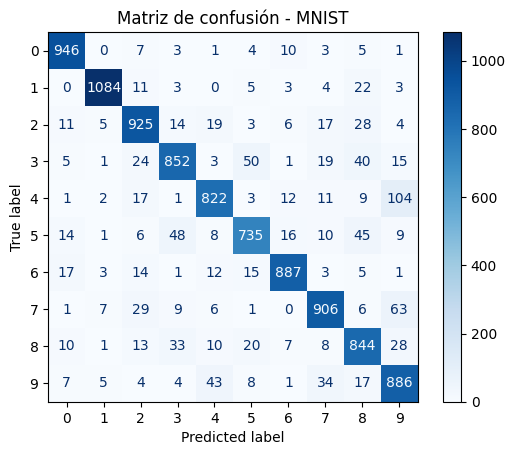

In [19]:
# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de confusión - MNIST")
plt.show()

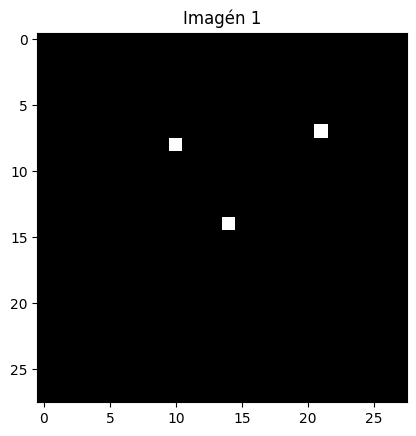

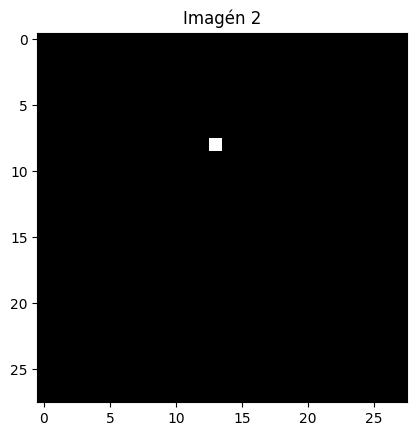

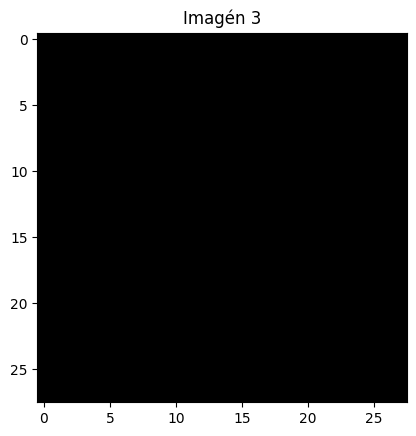

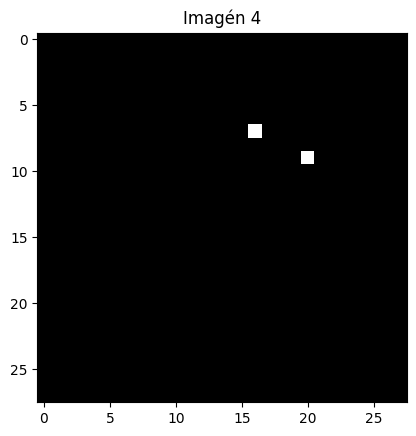

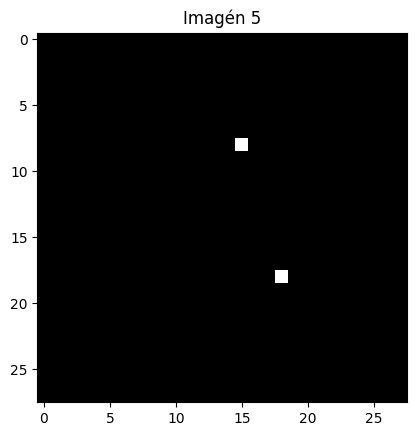

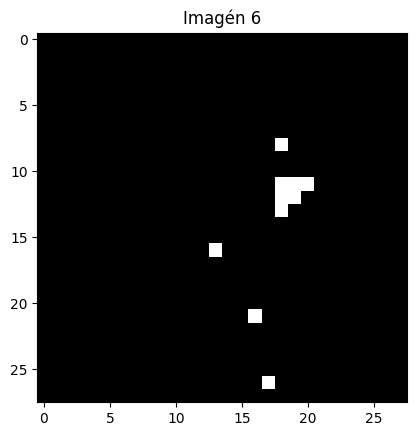

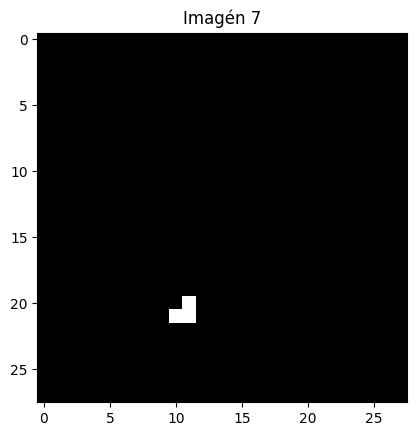

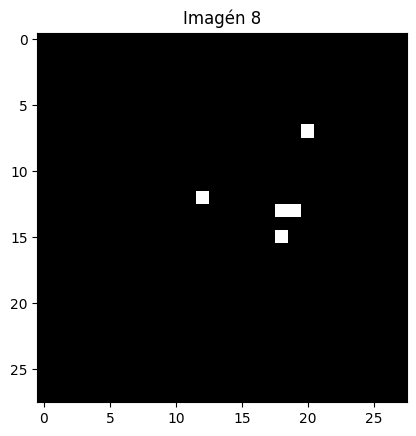

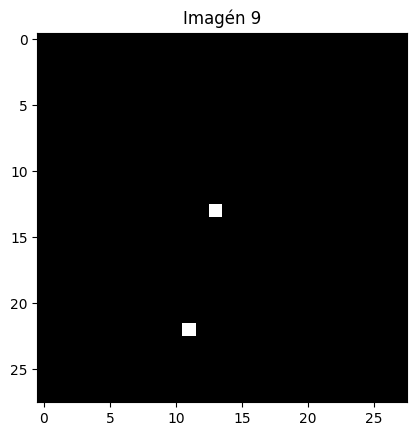

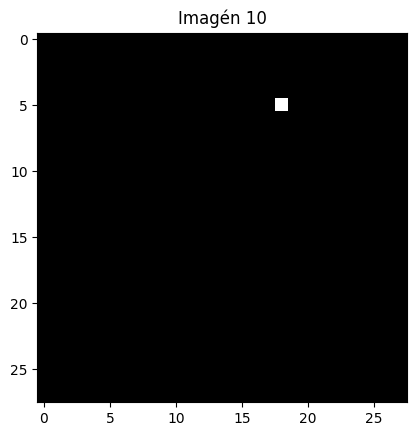

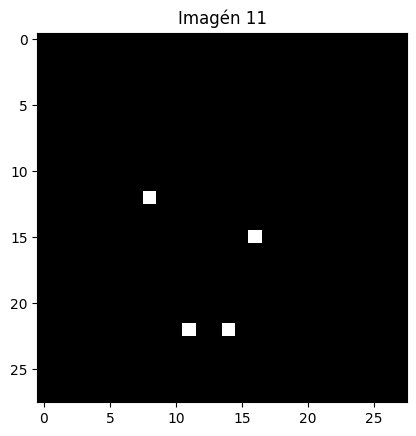

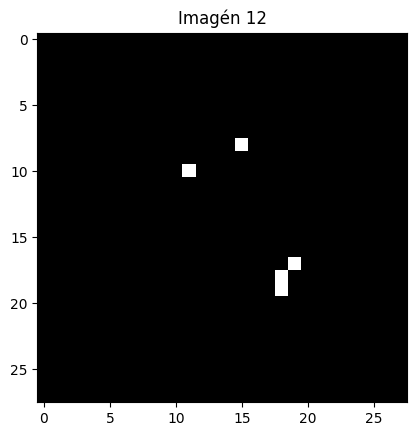

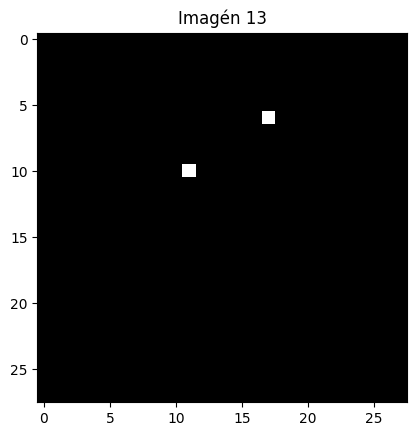

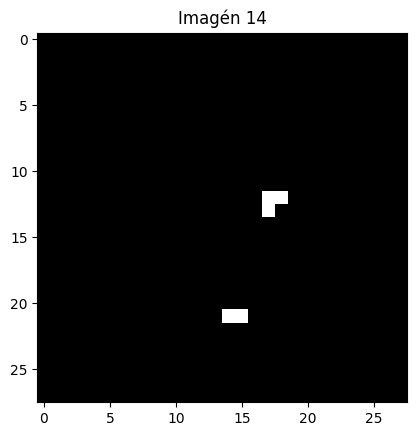

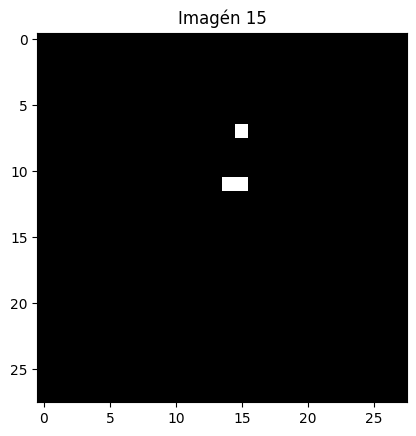

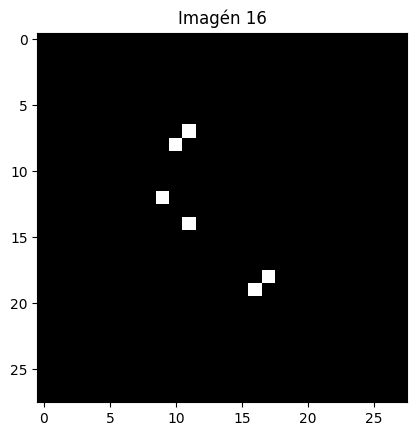

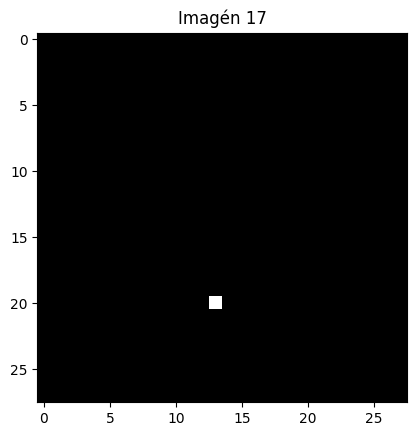

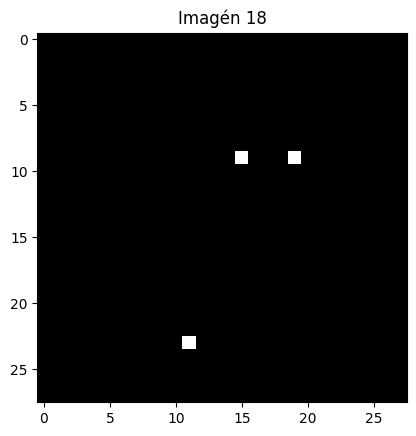

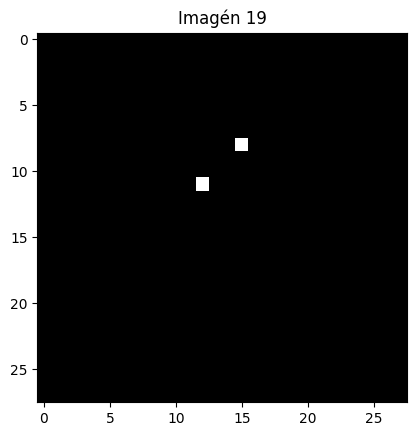

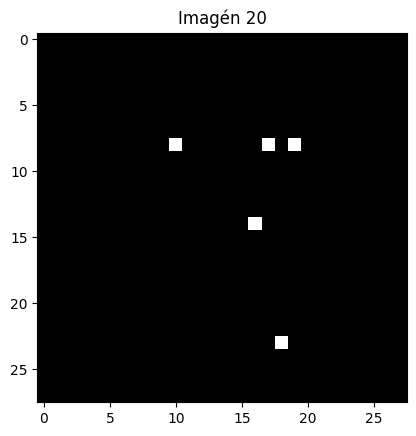

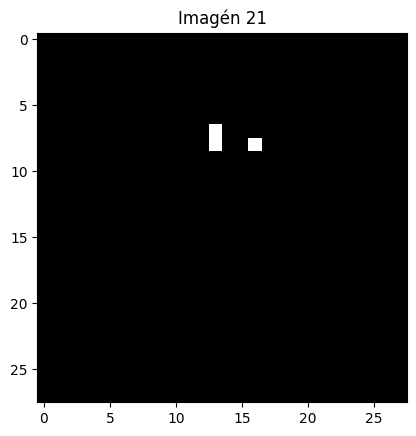

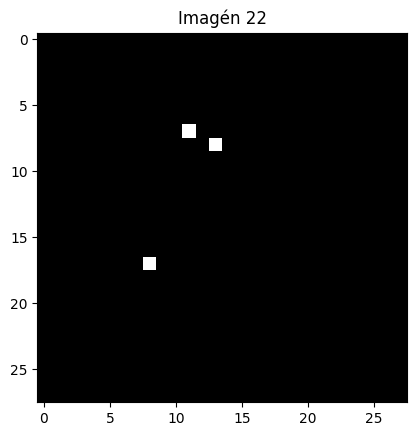

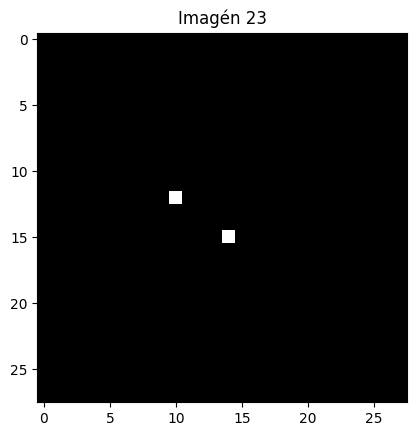

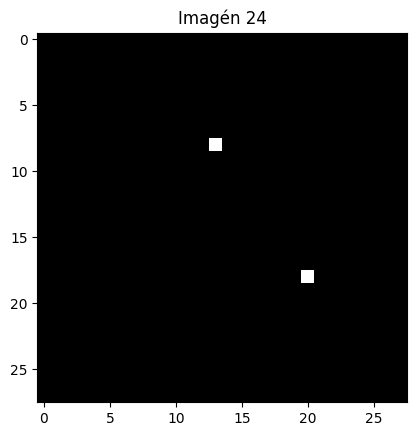

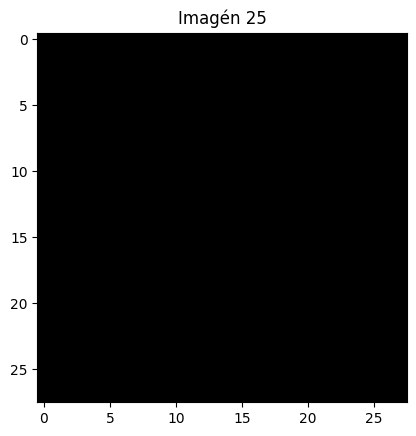

In [28]:
# Función para generar imágenes a partir del modelo DBN
def generate_images(model, num_images=5):
    model.eval()  # Modo evaluación

    with torch.inference_mode():
        for i in range(num_images):
            # Crear una muestra aleatoria en la última capa latente
            h = torch.bernoulli(torch.rand(1, sizes[-2])).to(device)  # Generar una muestra aleatoria en la última capa
    
            # Propagamos hacia atrás para obtener los datos visibles
            for rbm in reversed(model.subnet):
                _, v = rbm.sample_v(h)  # Generar las visibles desde las ocultas
                h = v  # Las visibles generadas se convierten en las entradas para la siguiente capa
    
            # Reestructurar los datos generados a imágenes 28x28
            generated_image = v.view(28, 28).cpu().numpy()
    
            # Visualizar la imagen generada
            plt.imshow(generated_image, cmap='gray')
            plt.title(f"Imagén {i+1}")
            plt.show()

# Generar imágenes a partir del modelo entrenado
generate_images(model, num_images=25)